In [272]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils

using CairoMakie
using DelimitedFiles
using Distributions
using LinearAlgebra

In [273]:
show_matrix(A) = show(stdout, "text/plain", A)

show_matrix (generic function with 1 method)

In [274]:
# Check previous solutions

In [275]:
# Operators 
const n_levels = 2
at = create(n_levels)
a = annihilate(n_levels)

H_operators = Dict(
        "X" => a + at,
        "Y" => -im * (a - at),
        "Z" => I - 2 * at * a,
)

# Time
T = 50
# Δt = 0.2
Δt = 2/9

# Crosstalk sweep
ζs = range(0, 0.1, length=51)
;

In [276]:
default = load_traj("saved-pulses-2023-12-13/single_qubit_gateset_default.jld2")
solution = load_traj("saved-pulses-2023-12-13/single_qubit_gateset_R1e-3.jld2")

NamedTrajectory{Float64}([1.0 1.0 … 0.00016529618168427212 2.9744052713542968e-5; 0.0 1.3161129312195462e-202 … -2.7862222030586486e-202 -2.585644411962143e-202; … ; 0.0861771827839917 0.12157514940375651 … 7.146449341470691e-7 0.0; 0.13191813059755544 0.22026389857295195 … 0.02260424968574804 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, -0.501584756788442, -0.09927368329434638, -0.17671271619945877, 0.39922019666262437, 0.0, 0.0, 0.0, 0.0], 50, 0.2222222222222222, 524, (Ũ⃗ = 512, a = 4, da = 4, dda = 4, states = 520, controls = 4), (a = ([-Inf, -Inf, -Inf, -Inf], [Inf, Inf, Inf, Inf]), dda = ([-Inf, -Inf, -Inf, -Inf], [Inf, Inf, Inf, Inf])), (Ũ⃗ = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], a = [0.0, 0.0, 0.0, 0.0]), (a = [0.0, 0.0, 0.0, 0.0],), (Ũ⃗ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],), (Ũ⃗ = 1:512, a = 513:516, da = 517:520, dda 

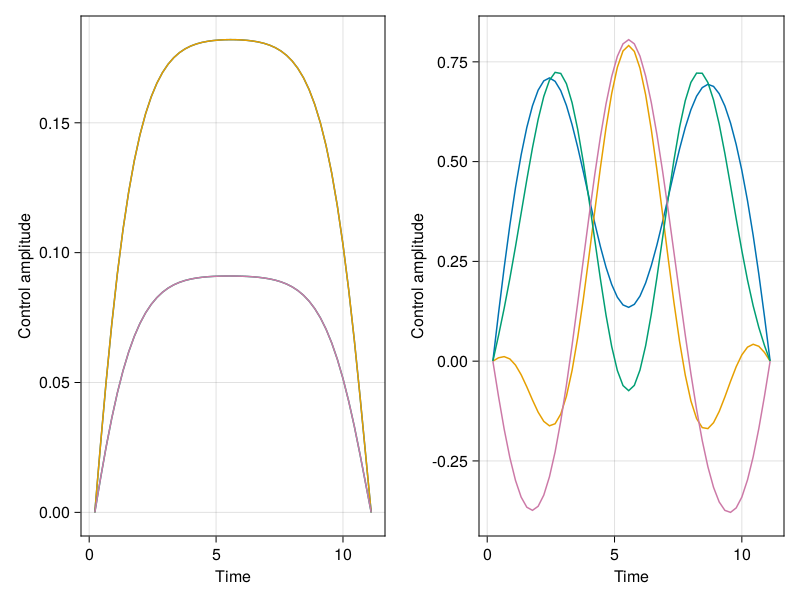

In [277]:
fig = Figure()
ts = accumulate(+, timesteps(default))
ax1 = Axis(fig[1,1], xlabel = "Time", ylabel = "Control amplitude")
ax2 = Axis(fig[1,2], xlabel = "Time", ylabel = "Control amplitude")
for row in eachrow(default[:a])
    lines!(ax1, ts, row)
end
for row in eachrow(solution[:a])
    lines!(ax2, ts, row)
end
fig

In [278]:
H_drift = zeros(n_levels^2, n_levels^2)
H_crosstalk = kron_from_dict("ZZ", H_operators)
H_controls = [
    kron_from_dict("XI", H_operators),
    kron_from_dict("IX", H_operators),
]
sys = QuantumSystem(H_drift, H_controls)
sys_xtalk_fn(s) = QuantumSystem(H_drift + s * H_crosstalk, H_controls)
;

In [279]:
# uf = iso_vec_to_operator(unitary_rollout(u0, default[:a][1:2, :], Δt, sys)[:, end])
# uf = iso_vec_to_operator(unitary_rollout(u0, solution[:a][1:2, :], Δt, sys)[:, end])
# uf = iso_vec_to_operator(unitary_rollout(u0, solution[:a][1:2, :], Δt, sys_xtalk)[:, end])
# uf = iso_vec_to_operator(unitary_rollout(u0, default[:a][1:2, :], Δt, sys_xtalk)[:, end])

In [280]:
function my_fn(controls, system, target)
    u0 = operator_to_iso_vec(kron_from_dict("II", H_operators))
    Uf = iso_vec_to_operator(unitary_rollout(u0, controls, Δt, system)[:, end])
    return 1 - unitary_fidelity(Uf, target)
end

my_fn (generic function with 1 method)

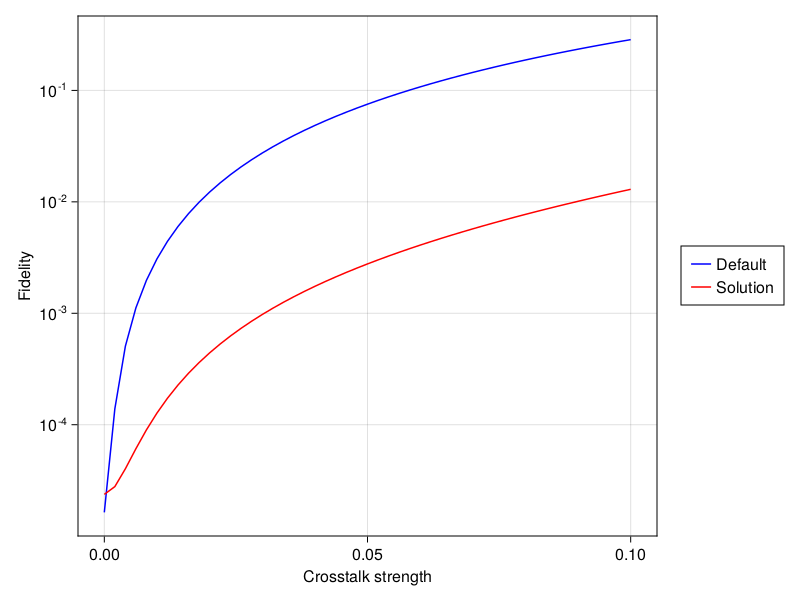

In [281]:
target = GATES[:X] ⊗ GATES[:X]

def_xtalk_res = [my_fn(default[:a][1:2, :], sys_xtalk_fn(s), target) for s in ζs]
sol_xtalk_res = [my_fn(solution[:a][1:2, :], sys_xtalk_fn(s), target) for s in ζs]

fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xlabel = "Crosstalk strength", ylabel = "Fidelity")
l1 = lines!(ax, ζs, def_xtalk_res, color = :blue)
l2 = lines!(ax, ζs, sol_xtalk_res, color = :red, label = "Solution")
Legend(fig[1,2], [l1, l2], ["Default", "Solution"])
fig

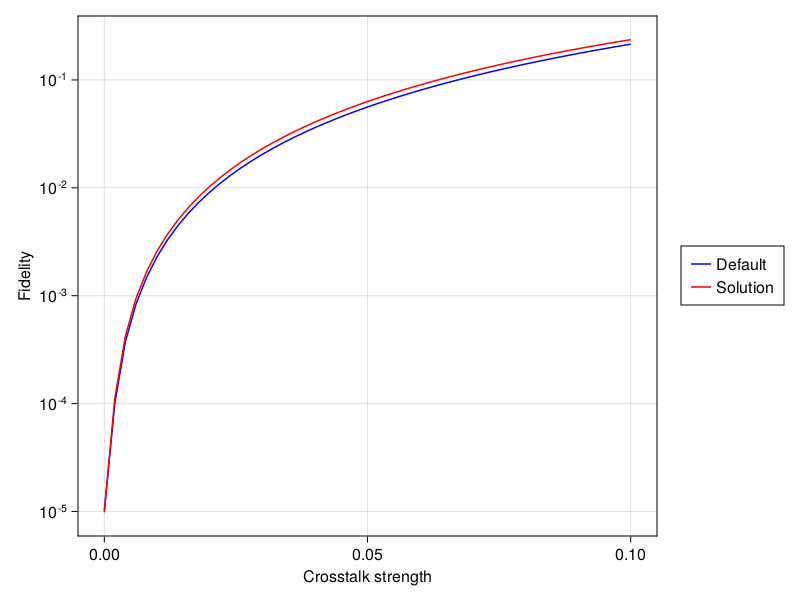

In [282]:
target = GATES[:X] ⊗ sqrt(GATES[:X])

def_xtalk_res = [my_fn(default[:a][[1,3], :], sys_xtalk_fn(s), target) for s in ζs]
sol_xtalk_res = [my_fn(solution[:a][[1,3], :], sys_xtalk_fn(s), target) for s in ζs]

fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xlabel = "Crosstalk strength", ylabel = "Fidelity")
l1 = lines!(ax, ζs, def_xtalk_res, color = :blue)
l2 = lines!(ax, ζs, sol_xtalk_res, color = :red, label = "Solution")
Legend(fig[1,2], [l1, l2], ["Default", "Solution"])
fig

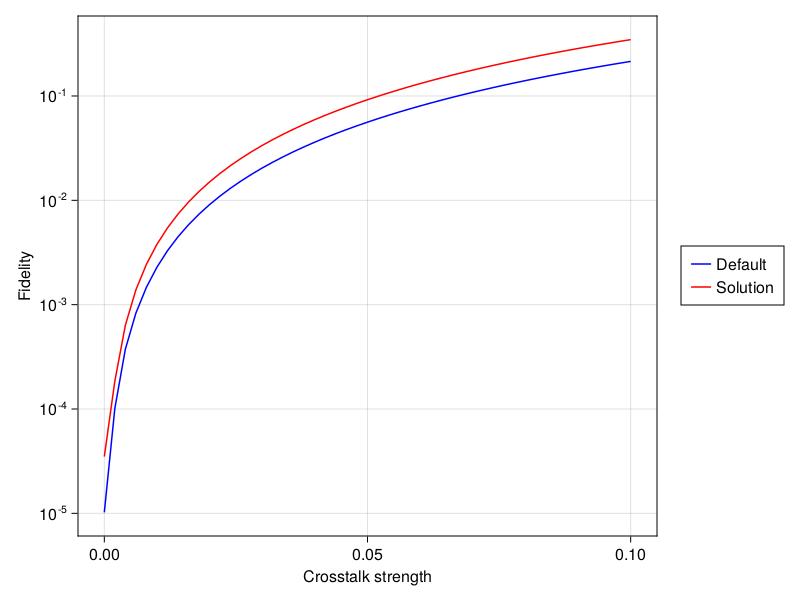

In [283]:
target = GATES[:X] ⊗ sqrt(GATES[:X])

def_xtalk_res = [my_fn(default[:a][[2,4], :], sys_xtalk_fn(s), target) for s in ζs]
sol_xtalk_res = [my_fn(solution[:a][[2,4], :], sys_xtalk_fn(s), target) for s in ζs]

fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xlabel = "Crosstalk strength", ylabel = "Fidelity")
l1 = lines!(ax, ζs, def_xtalk_res, color = :blue)
l2 = lines!(ax, ζs, sol_xtalk_res, color = :red, label = "Solution")
Legend(fig[1,2], [l1, l2], ["Default", "Solution"])
fig

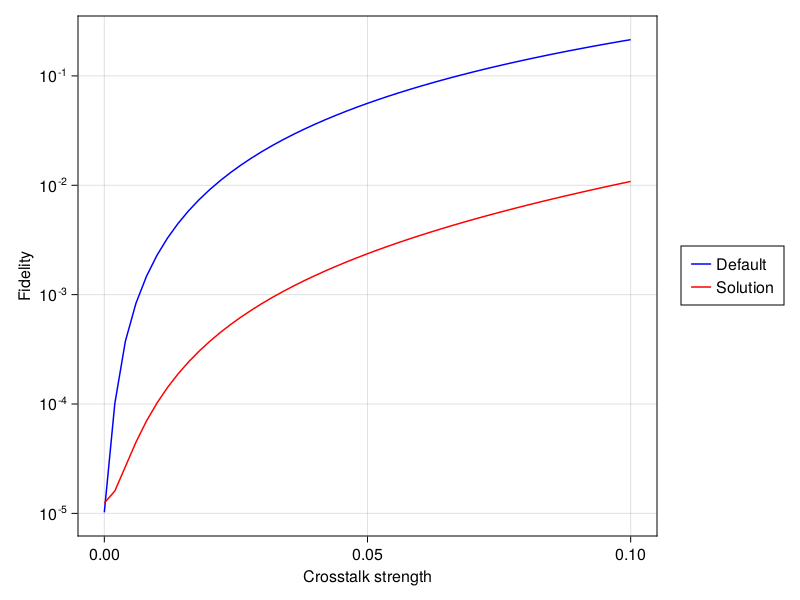

In [284]:
target = GATES[:X] ⊗ sqrt(GATES[:X])

def_xtalk_res = [my_fn(default[:a][[1,4], :], sys_xtalk_fn(s), target) for s in ζs]
sol_xtalk_res = [my_fn(solution[:a][[1,4], :], sys_xtalk_fn(s), target) for s in ζs]

fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xlabel = "Crosstalk strength", ylabel = "Fidelity")
l1 = lines!(ax, ζs, def_xtalk_res, color = :blue)
l2 = lines!(ax, ζs, sol_xtalk_res, color = :red, label = "Solution")
Legend(fig[1,2], [l1, l2], ["Default", "Solution"])
fig

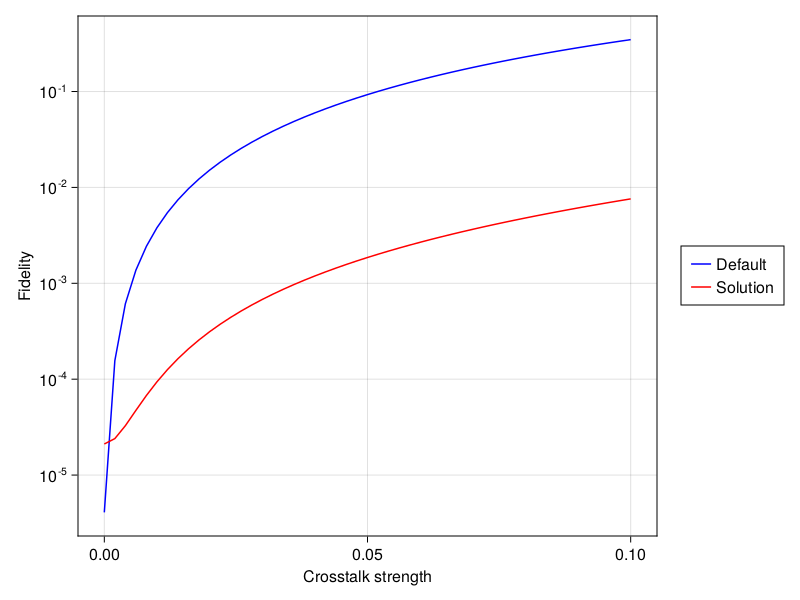

In [285]:
target = sqrt(GATES[:X]) ⊗ sqrt(GATES[:X])

def_xtalk_res = [my_fn(default[:a][[3,4], :], sys_xtalk_fn(s), target) for s in ζs]
sol_xtalk_res = [my_fn(solution[:a][[3,4], :], sys_xtalk_fn(s), target) for s in ζs]

fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xlabel = "Crosstalk strength", ylabel = "Fidelity")
l1 = lines!(ax, ζs, def_xtalk_res, color = :blue)
l2 = lines!(ax, ζs, sol_xtalk_res, color = :red, label = "Solution")
Legend(fig[1,2], [l1, l2], ["Default", "Solution"])
fig

# ECR gate

In [286]:
ZX = kron_from_dict("ZX", H_operators)
XZ = kron_from_dict("XZ", H_operators)
XI = kron_from_dict("XI", H_operators)
IX = kron_from_dict("IX", H_operators)
XY = kron_from_dict("XY", H_operators)
YX = kron_from_dict("YX", H_operators)

4×4 Matrix{ComplexF64}:
  0.0-0.0im   0.0-0.0im  0.0-0.0im  0.0-1.0im
  0.0-0.0im   0.0-0.0im  0.0-1.0im  0.0-0.0im
 -0.0+0.0im  -0.0+1.0im  0.0-0.0im  0.0-0.0im
 -0.0+1.0im  -0.0+0.0im  0.0-0.0im  0.0-0.0im

In [287]:
R = im * √2 * exp(im * π/8 * XZ) * exp(-im * π/2 * IX) * exp(-im * π/8 * XZ) #* exp(-im * π/2 * XI)
show_matrix(round.(R, digits=4))

4×4 Matrix{ComplexF64}:
  0.0+0.0im  1.0+0.0im  0.0+0.0im   0.0+1.0im
  1.0+0.0im  0.0+0.0im  0.0-1.0im  -0.0+0.0im
 -0.0+0.0im  0.0+1.0im  0.0+0.0im   1.0+0.0im
  0.0-1.0im  0.0+0.0im  1.0+0.0im   0.0+0.0im

In [288]:
show_matrix(IX - XY)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+1.0im
 1.0+0.0im  0.0+0.0im  0.0-1.0im  0.0+0.0im
 0.0+0.0im  0.0+1.0im  0.0+0.0im  1.0+0.0im
 0.0-1.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

Careful on ordering in Qiskit.

In [289]:
R = im * √2 * exp(im * π/8 * ZX) * exp(-im * π/2 * XI) * exp(-im * π/8 * ZX) #* exp(-im * π/2 * XI)
show_matrix(round.(R, digits=4))

4×4 Matrix{ComplexF64}:
  0.0+0.0im  0.0+0.0im  1.0+0.0im   0.0+1.0im
 -0.0+0.0im  0.0+0.0im  0.0+1.0im   1.0+0.0im
  1.0+0.0im  0.0-1.0im  0.0+0.0im  -0.0+0.0im
  0.0-1.0im  1.0+0.0im  0.0+0.0im   0.0+0.0im

In [290]:
show_matrix(XI - YX)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+1.0im
 0.0+0.0im  0.0+0.0im  0.0+1.0im  1.0+0.0im
 1.0+0.0im  0.0-1.0im  0.0+0.0im  0.0+0.0im
 0.0-1.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im